In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from datetime import datetime, timedelta

In [2]:
edges_dataset = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv', )
features_names = ['txId'] + ['x%i' %i for i in range(166)]
features_dataset = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_features.csv', names=features_names)
classes_dataset = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_classes.csv')

In [7]:
edges_dataset

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206
...,...,...
234350,158365409,157930723
234351,188708874,188708879
234352,157659064,157659046
234353,87414554,106877725


In [3]:
classes_dataset.shape, edges_dataset.shape, features_dataset.shape

((203769, 2), (234355, 2), (203769, 167))

### Transforming the edge list label

There is a time component to the graphs but we will ignore it and consider everything as 1 graph.

<AxesSubplot:xlabel='x0'>

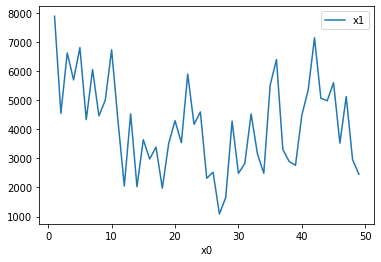

In [12]:
features_dataset[['x0','x1']].groupby('x0').count().plot();

In [ ]:
current_idx_to_simple_idx = {current_idx: simple_idx for simple_idx, current_idx in enumerate(classes_dataset['txId'].to_numpy())}
edges_dataset['txId1'] = edges_dataset['txId1'].apply(lambda x: current_idx_to_simple_idx[x])
edges_dataset['txId2'] = edges_dataset['txId2'].apply(lambda x: current_idx_to_simple_idx[x])

In [ ]:
edges_dataset.head(3)

### Transforming the class label

In [ ]:
classes_dataset.head(4)

In [ ]:
classes_dataset['class'].hist();

In [ ]:
classes_dataset.loc[classes_dataset['class']=='unknown','class'] = None
classes_dataset.loc[classes_dataset['class']=='1','class'] = 0
classes_dataset.loc[classes_dataset['class']=='2','class'] = 1
classes_dataset['class'] = classes_dataset['class'].astype(float)

In [ ]:
features_dataset.head(2)

### Transforming the features label
1. Removing features highly correlated between each other

In [ ]:
pair_highly_correlated_features = abs(features_dataset.sample(40000).corr()) > 0.92
pair_highly_correlated_features.head(1)

In [ ]:
correlated_pair_features = np.argwhere((pair_highly_correlated_features==True).values)
correlated_pair_features = correlated_pair_features[correlated_pair_features[:,0] != correlated_pair_features[:,1]]

In [ ]:
lead_feature = {}
child_feature = {} # keys of which will be deleted
for idx in range(len(correlated_pair_features)):
    left_feature = correlated_pair_features[idx,0]
    right_feature = correlated_pair_features[idx,1]
    if lead_feature.get(left_feature) is None and lead_feature.get(right_feature) is None and child_feature.get(left_feature) is None: # neither left or right is a boss, make left boss
        lead_feature[left_feature] = []
        lead_feature[left_feature].append(right_feature)
        child_feature[right_feature] = left_feature
    elif lead_feature.get(left_feature) is not None and lead_feature.get(right_feature) is None  : # new child for left feature
        lead_feature[left_feature].append(right_feature)
        child_feature[right_feature] = left_feature
    else: # other cases are if right feature is not None, that means already a boss
        continue 

print("Number of features deleting : ", len(child_feature.keys()))

In [ ]:
columns_to_drop = features_dataset.columns[list(child_feature.keys())]
features_dataset.drop(columns_to_drop,axis=1,inplace=True)

In [ ]:
features_dataset.to_pickle('elliptic_bitcoin_dataset/elliptic_txs_features_light.pkl')
classes_dataset.to_pickle('elliptic_bitcoin_dataset/elliptic_txs_classes_transformed.pkl')
edges_dataset.to_pickle('elliptic_bitcoin_dataset/elliptic_txs_edgelist_transformed.pkl')

In [ ]:
classes_dataset